In [1]:
import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir("../..")

In [5]:
import logging
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from hydra import compose, initialize

plt.style.use("ggplot")

from scipy.stats import kurtosis, skew
from src.preprocessing import ClassicDataset
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from adjustText import adjust_text
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import umap

In [6]:
# Paths and file names
config_path = os.path.join("..", "..", "config", "dataset")
config_files = [
    os.path.splitext(f)[0]
    for f in os.listdir(os.path.join(os.path.abspath("."), config_path[6:]))
    if f.endswith(".yaml")
]

In [7]:
def get_dataset_features(
    ratings: pd.DataFrame,
    user_id: str = "userId",
    item_id: str = "itemId",
    rating_col: str = "rating",
) -> dict:
    """
    Calculate various features from the ratings DataFrame.

    Parameters:
        ratings (pd.DataFrame): DataFrame containing user-item ratings.
        user_id (str): Name of the column representing user IDs.
        item_id (str): Name of the column representing item IDs.
        rating_col (str): Name of the column representing ratings.

    Returns:
        dict: A dictionary containing calculated features.
    """
    # 1-3 Basic features
    U = ratings[user_id].nunique()
    I = ratings[item_id].nunique()
    R = ratings.shape[0]

    # 4 SpaceSize
    SpaceSize = U * I

    # 5 Shape
    Shape = U / I

    # 6  Density
    Density = R / SpaceSize

    # 7, 8 Rating per user and Rating per item
    Rpu = R / U
    Rpi = R / I

    # 9, 10 Ginii and Giniu
    Ri_counts = ratings[item_id].value_counts().values[::-1]
    Ru_counts = ratings[user_id].value_counts().values[::-1]
    Ginii = 1 - 2 * np.sum((I + 1 - np.arange(1, I + 1)) * Ri_counts) / ((I + 1) * R)
    Giniu = 1 - 2 * np.sum((U + 1 - np.arange(1, U + 1)) * Ru_counts) / ((U + 1) * R)

    # 11-14 Polularity biases
    avg_item_popularity = ratings.groupby(item_id)[user_id].nunique() / U
    ratings = ratings.join(avg_item_popularity.rename("item_popularity", inplace=False), on=item_id)
    popularity_bias = ratings.groupby(user_id)["item_popularity"].mean()
    APB = popularity_bias.mean()
    StPB = popularity_bias.std()
    SkPB = skew(popularity_bias)
    KuPB = kurtosis(popularity_bias)

    # 15-18 Long tail items
    item_popularity = ratings[item_id].value_counts()
    item_popularity_cumsum = item_popularity.cumsum()
    LT_index = np.argmax(item_popularity_cumsum / R > 0.8)
    LT_items = set(item_popularity.iloc[LT_index:].index)
    LT_items_percentage = ratings.groupby(user_id)[item_id].apply(
        lambda x: len(set(x) & LT_items) / len(set(x)) if len(set(x)) > 0 else 0
    )
    LTavg = LT_items_percentage.mean()
    LTstd = LT_items_percentage.std()
    LTsk = skew(LT_items_percentage)
    LTku = kurtosis(LT_items_percentage)

    return {
        "Nu": U,
        "Ni": I,
        "Nr": R,
        "SpaceSize": SpaceSize,
        "Shape": Shape,
        "Density": Density,
        "Rpu": Rpu,
        "Rpi": Rpi,
        "Ginii": Ginii,
        "Giniu": Giniu,
        "APB": APB,
        "StPB": StPB,
        "SkPB": SkPB,
        "KuPB": KuPB,
        "LTavg": LTavg,
        "LTstd": LTstd,
        "LTsk": LTsk,
        "LTku": LTku,
    }

In [8]:
def get_cold_items(
    train_set: pd.DataFrame, val_set: pd.DataFrame, test_set: pd.DataFrame, column: str
):
    """
    Calculate the fraction of items that only appear in the validation set and the test set,
    but not in the training set.

    Parameters:
        train_set (pandas.DataFrame): The training dataset.
        val_set (pandas.DataFrame): The validation dataset.
        test_set (pandas.DataFrame): The test dataset.
        column (str): The name of the column containing the items.

    Returns:
        tuple: A tuple containing two fractions:
            - fraction_items_only_in_val_set (float): The fraction of items only in the validation set.
            - fraction_items_only_in_test_set (float): The fraction of items only in the test set.
    """
    items_train_set = set(train_set[column])
    items_val_set = set(val_set[column])
    items_test_set = set(test_set[column])
    fraction_items_only_in_val_set = len(items_val_set - items_train_set) / len(
        items_val_set
    )
    fraction_items_only_in_test_set = len(items_test_set - items_train_set) / len(
        items_test_set
    )
    return fraction_items_only_in_val_set, fraction_items_only_in_test_set

In [10]:
statistics_raw = dict()
statistics_filtered = dict()
statistics_wo_cold_iu = dict()
for config_file in tqdm(config_files, desc="Processing config files"):
    with initialize(config_path=config_path, version_base=None):
        cfg_data = compose(config_name=config_file)
    # init some constants
    user_id = cfg_data["user_column"]
    item_id = cfg_data["item_column"]
    rating_col = cfg_data["rating_column"]
    date_col = cfg_data["date_column"]
    splitting_conf = cfg_data["splitting"]
    # train_size = splitting_conf["train_size"]
    # val_size = splitting_conf["val_size"]
    # test_size = splitting_conf["test_size"]
    train_size = .8
    val_size = .1
    test_size = .1


    if train_size + val_size + test_size != 1:
        raise ValueError("Expected total fraction equal to 1")

    # get raw data
    ratings = pd.read_parquet(
        os.path.join(cfg_data["data_src"], cfg_data["ratings_file"])
    )

    # get raw dataset features
    statistics_raw[cfg_data["name"]] = get_dataset_features(
        ratings, user_id, item_id, rating_col
    )

    # get filtered dataset features
    ds = ClassicDataset()
    ds.prepare(cfg_data)
    interactions_processed = ds.prepared_data
    
    # get filtered dataset features
    statistics_filtered[cfg_data["name"]] = get_dataset_features(
        interactions_processed, user_id, item_id, rating_col
    )
    # Make train/val/test split without filtering
    interactions_processed.sort_values(date_col, inplace=True)
    date_at_val_percentile = interactions_processed[date_col].quantile(
        1 - val_size - test_size
    )
    date_at_test_percentile = interactions_processed[date_col].quantile(1 - test_size)

    train_set = interactions_processed[
        interactions_processed[date_col] <= date_at_val_percentile
    ]
    val_set = interactions_processed[
        (interactions_processed[date_col] > date_at_val_percentile)
        & (interactions_processed[date_col] <= date_at_test_percentile)
    ]
    test_set = interactions_processed[
        interactions_processed[date_col] > date_at_test_percentile
    ]

    # Get cold users
    cold_users_val, cold_users_test = get_cold_items(
        train_set, val_set, test_set, user_id
    )
    statistics_filtered[cfg_data["name"]]["ColdUsersVal"] = cold_users_val
    statistics_filtered[cfg_data["name"]]["ColdUsersTest"] = cold_users_test
    # Get cold items
    cold_items_val, cold_items_test = get_cold_items(
        train_set, val_set, test_set, item_id
    )
    statistics_filtered[cfg_data["name"]]["ColdItemsVal"] = cold_items_val
    statistics_filtered[cfg_data["name"]]["ColdItemsTest"] = cold_items_test

    # filtering Cold users and Items
    train_users = set(train_set[user_id])
    train_items = set(train_set[item_id])
    val_set = val_set[
        val_set[user_id].isin(train_users) & val_set[item_id].isin(train_items)
    ]
    test_set = test_set[
        test_set[user_id].isin(train_users) & test_set[item_id].isin(train_items)
    ]

    # get splitted and filtered dataset features
    data_splitted = pd.concat([train_set, val_set, test_set])
    data_splitted.reset_index(drop=True, inplace=True)
    
    statistics_wo_cold_iu[cfg_data["name"]] = get_dataset_features(
        data_splitted, user_id, item_id, rating_col
    )
    
    # some additional features
    statistics_wo_cold_iu[cfg_data["name"]]["FracInteractionsVal"] = len(val_set) / (
        len(data_splitted)
    )
    statistics_wo_cold_iu[cfg_data["name"]]["FracInteractionsTest"] = len(test_set) / (
        len(data_splitted)
    )
    
    statistics_wo_cold_iu[cfg_data["name"]]["FracPassiveUsersVal"] = val_set[user_id].nunique() / (
        data_splitted[user_id].nunique()
    )
    statistics_wo_cold_iu[cfg_data["name"]]["FracPassiveUsersTest"] = test_set[user_id].nunique() / (
        data_splitted[user_id].nunique()
    )
    
    statistics_wo_cold_iu[cfg_data["name"]]["FracPassiveItemsVal"] = val_set[item_id].nunique() / (
        data_splitted[item_id].nunique()
    )
    statistics_wo_cold_iu[cfg_data["name"]]["FracPassiveItemsTest"] = test_set[item_id].nunique() / (
        data_splitted[item_id].nunique()
    )
    
    # timestamps 
    # full data
    if len(str(int(ratings[date_col][0]))) > 11:
        unit = 'ns'
    elif len(str(int(ratings[date_col][0]))) > 6:
        unit = 's'
    else:
        unit = 'W'
        
    data_splitted[date_col] = pd.to_datetime(data_splitted[date_col], unit=unit)
    statistics_wo_cold_iu[cfg_data["name"]]["MinDate"] = data_splitted[date_col].min().to_pydatetime()
    statistics_wo_cold_iu[cfg_data["name"]]["MaxDate"] = data_splitted[date_col].max().to_pydatetime()

    # validation Set
    val_set[date_col] = pd.to_datetime(val_set[date_col], unit=unit)
    statistics_wo_cold_iu[cfg_data["name"]]["ValDate"] = val_set[date_col].min().to_pydatetime()
    statistics_wo_cold_iu[cfg_data["name"]]["DeltaVal"] = (val_set[date_col].max() - val_set[date_col].min()).days

    # test Set
    test_set[date_col] = pd.to_datetime(test_set[date_col], unit=unit)
    statistics_wo_cold_iu[cfg_data["name"]]["TestDate"] =  test_set[date_col].min().to_pydatetime()
    statistics_wo_cold_iu[cfg_data["name"]]["DeltaTest"] = (test_set[date_col].max() - test_set[date_col].min()).days

with open(os.path.join("results", "datasets_statistics", "statistics_raw.pcl"), "wb") as f:
    pickle.dump(statistics_raw, f)
with open(os.path.join("results", "datasets_statistics", "statistics_filtered.pcl"), "wb") as f:
    pickle.dump(statistics_filtered, f)
with open(os.path.join("results", "datasets_statistics", "statistics_wo_cold_iu.pcl"), "wb") as f:
    pickle.dump(statistics_wo_cold_iu, f)

Processing config files:   0%|          | 0/39 [00:00<?, ?it/s]

Processing config files:   5%|▌         | 2/39 [00:22<06:53, 11.19s/it]


FileNotFoundError: data/amazon_books/Books.parquet

In [5]:
with open(os.path.join("results", "datasets_statistics", "statistics_raw.pcl"), "rb") as f:
    statistics_raw = pickle.load(f)
with open(os.path.join("results", "datasets_statistics", "statistics_filtered.pcl"), "rb") as f:
    statistics_filtered = pickle.load(f)
with open(os.path.join("results", "datasets_statistics", "statistics_wo_cold_iu.pcl"), "rb") as f:
    statistics_wo_cold_iu = pickle.load(f)

In [6]:
# Convert the dictionary to a pandas DataFrame
statistics_raw_df = pd.DataFrame(statistics_raw).T
statistics_filtered_df = pd.DataFrame(statistics_filtered).T
statistics_wo_cold_iu_df = pd.DataFrame(statistics_wo_cold_iu).T

In [7]:
statistics_wo_cold_iu_df

,Nu,Ni,Nr,SpaceSize,Shape,Density,Rpu,Rpi,Ginii,Giniu,...,FracPassiveUsersVal,FracPassiveUsersTest,FracPassiveItemsVal,FracPassiveItemsTest,MinDate,MaxDate,ValDate,DeltaVal,TestDate,DeltaTest
xwines,876184,93510,15838958,81931965840,9.36995,0.000193,18.077205,169.382505,0.722008,0.496205,...,0.435492,0.39347,0.810651,0.803732,2012-01-03 08:27:03.000000,2021-12-31 23:59:56.000000,2020-12-06 14:40:27.000000,185,2021-06-10 09:59:55.000000,204
netflix,397369,17368,51934136,6901504792,22.879376,0.007525,130.694986,2990.219714,0.857593,0.575886,...,0.533965,0.496591,0.933671,0.935571,1999-11-11 00:00:00.000000,2005-12-31 00:00:00.000000,2005-08-15 00:00:00.000000,56,2005-10-11 00:00:00.000000,81
amazon_cds,67844,108350,1102432,7350897400,0.626156,0.00015,16.249514,10.17473,0.495434,0.516415,...,0.437887,0.412608,0.206701,0.17761,1997-11-11 00:00:00.000000,2018-09-14 00:00:00.000000,2015-10-17 00:00:00.000000,371,2016-10-23 00:00:00.000000,691
lfm,119271,5445347,277509753,649471982037,0.021903,0.000427,2326.716075,50.962731,0.75473,0.572358,...,0.479161,0.429484,0.653829,0.603825,2005-02-14 00:00:46.000000,2023-05-26 21:56:42.000000,2013-10-15 08:33:53.000000,115,2014-02-08 05:47:28.000000,3394
mts,70549,58379,690996,4118580071,1.208465,0.000168,9.794554,11.83638,0.447626,0.394841,...,0.422458,0.425973,0.529129,0.537728,2018-01-01 00:00:00.000000,2019-12-31 00:00:00.000000,2019-08-24 00:00:00.000000,66,2019-10-30 00:00:00.000000,62
douban_music,992,4714,45489,4676288,0.210437,0.009728,45.855847,9.649767,0.335069,0.603249,...,0.43246,0.34879,0.377811,0.310352,2005-08-29 00:00:00.000000,2018-08-28 00:00:00.000000,2016-11-03 00:00:00.000000,324,2017-09-24 00:00:00.000000,338
amazon_books,597905,1697905,20183221,1015185889025,0.352143,0.00002,33.756568,11.887132,0.496884,0.676239,...,0.449908,0.387884,0.296503,0.218608,1996-05-20 00:00:00.000000,2018-10-02 00:00:00.000000,2017-01-10 00:00:00.000000,234,2017-09-02 00:00:00.000000,395
yahoo,835998,537055,109688384,448976905890,1.556634,0.000244,131.206515,204.240504,0.860888,0.651486,...,0.153472,0.103474,0.780449,0.712048,1999-11-11 17:30:00.000000,2010-09-27 14:19:00.000000,2007-02-16 23:39:00.000000,282,2007-11-26 12:16:00.000000,1036
amazon_tv,49428,207194,2193340,10241185032,0.238559,0.000214,44.374444,10.585924,0.409844,0.700268,...,0.550376,0.595209,0.314058,0.216425,1997-12-02 00:00:00.000000,2018-10-01 00:00:00.000000,2016-07-05 00:00:00.000000,209,2017-01-31 00:00:00.000000,608
beeradvocate,11631,17326,1108439,201518706,0.671303,0.0055,95.300404,63.97547,0.746221,0.732923,...,0.3317,0.263262,0.549002,0.511139,1998-01-10 00:00:01.000000,2012-01-11 09:00:38.000000,2011-01-29 01:00:32.000000,168,2011-07-16 04:47:36.000000,179


In [14]:
statistics_wo_cold_iu_df.SpaceSize.sort_values()

foursquare                 390888
kuairec_small             4104599
douban_music              4676288
douban_books              8076936
reddit                   14922927
movielens_1m             16760640
douban_movies            33461120
kuairec_full             58419816
rekko                    81393840
brightkite              134188124
amazon_finefoods        168923889
beeradvocate            201518706
ratebeer                224265390
epinions                326701870
tafeng                  377338368
movielens_10m           496085731
dianping                513135872
food                    710321264
movielens_20m          1377979020
retail_rocket          1448180134
mts                    4118580071
twitch                 6227406804
netflix                6901504792
amazon_cds             7350897400
goodreads              7758936950
gowalla               10211052540
amazon_tv             10241185032
yelp                  17744039547
yoochoose             33252476616
xwines        

In [8]:
statistics_wo_cold_iu_df.keys()

Index(['Nu', 'Ni', 'Nr', 'SpaceSize', 'Shape', 'Density', 'Rpu', 'Rpi',
       'Ginii', 'Giniu', 'APB', 'StPB', 'SkPB', 'KuPB', 'LTavg', 'LTstd',
       'LTsk', 'LTku', 'FracInteractionsVal', 'FracInteractionsTest',
       'FracPassiveUsersVal', 'FracPassiveUsersTest', 'FracPassiveItemsVal',
       'FracPassiveItemsTest', 'MinDate', 'MaxDate', 'ValDate', 'DeltaVal',
       'TestDate', 'DeltaTest'],
      dtype='object')

In [10]:
statistics_wo_cold_iu_df.Density.sort_values()[::-1]

kuairec_small        0.81715
kuairec_full        0.130792
foursquare          0.130004
movielens_1m        0.030805
douban_movies       0.018823
movielens_10m       0.009771
douban_music        0.009728
douban_books        0.007657
netflix             0.007525
movielens_20m       0.007277
ratebeer            0.005865
beeradvocate          0.0055
reddit              0.004689
rekko               0.002639
dianping            0.002351
tafeng              0.001821
brightkite          0.001074
epinions            0.000953
amazon_finefoods    0.000763
food                0.000713
lfm                 0.000427
twitch              0.000272
goodreads           0.000257
yoochoose           0.000246
yahoo               0.000244
retail_rocket       0.000217
amazon_tv           0.000214
xwines              0.000193
gowalla             0.000191
mts                 0.000168
amazon_cds           0.00015
yelp                0.000133
tmall               0.000044
amazon_books         0.00002
otto          

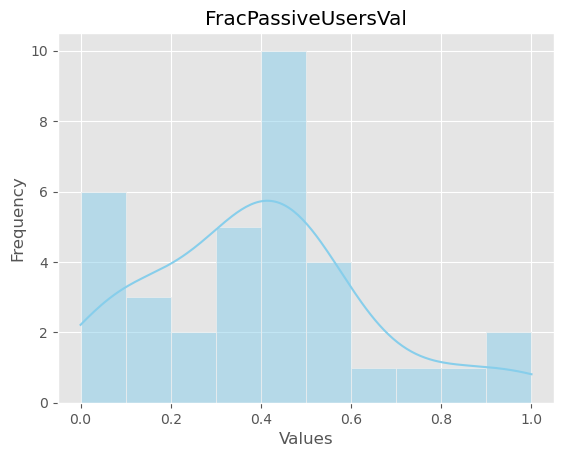

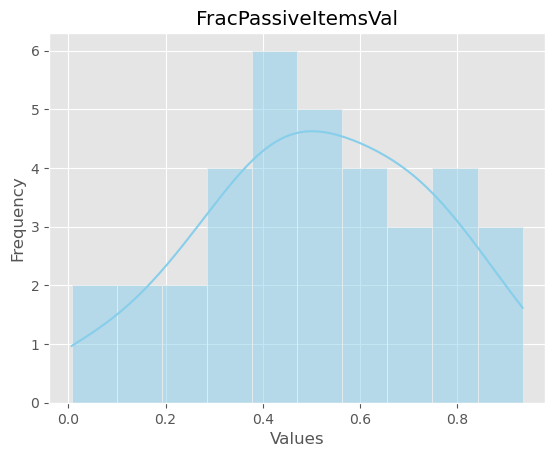

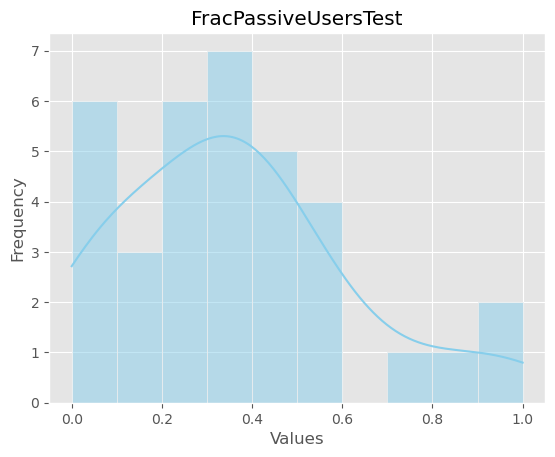

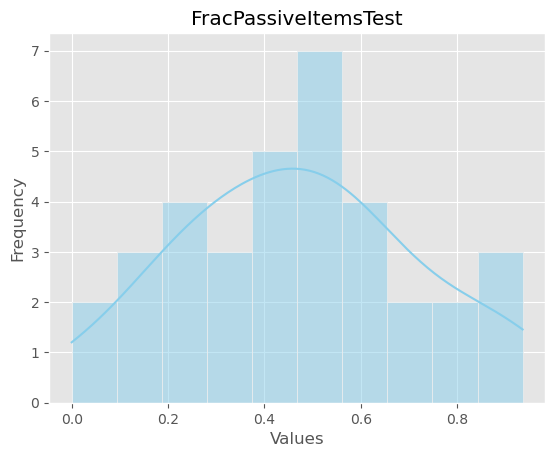

In [27]:
columns = ['FracPassiveUsersVal', 'FracPassiveItemsVal', 'FracPassiveUsersTest', 'FracPassiveItemsTest']

for column in columns:
    data = [statistics_wo_cold_iu[key][column] for key in statistics_wo_cold_iu]
    sns.histplot(data, kde=True, color='skyblue', bins=10)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(column)
    plt.show()

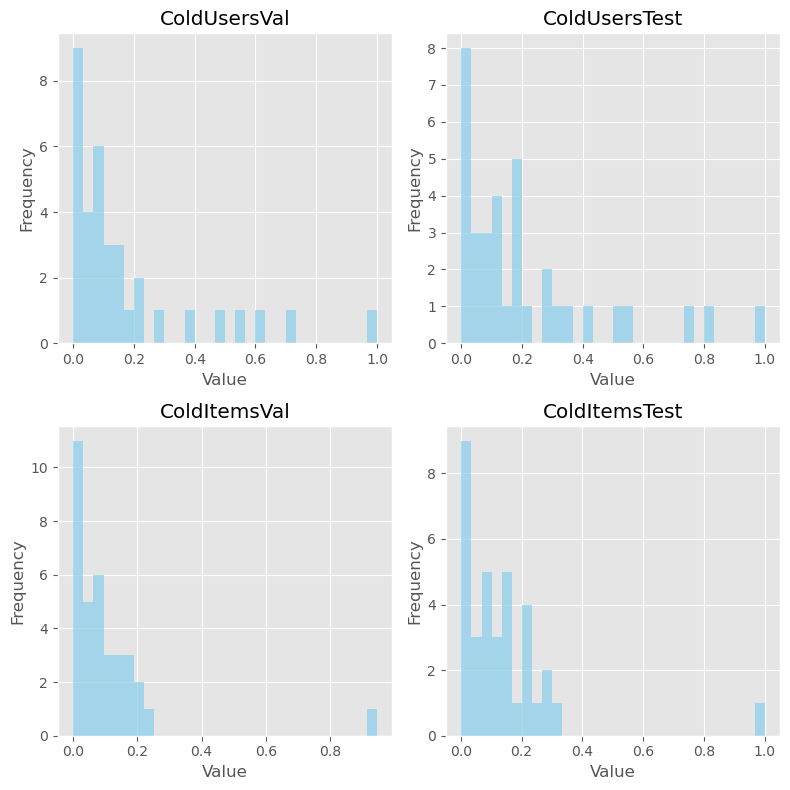

In [33]:
# Histograms for splitting 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

columns = ['ColdUsersVal', 'ColdUsersTest', 'ColdItemsVal', 'ColdItemsTest']
for i, column in enumerate(columns):
    row, col = i // 2, i % 2
    statistics_filtered_df[column].hist(ax=axes[row, col], color='skyblue', alpha=0.7, bins=30)
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel("Value")
    axes[row, col].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [44]:
statistics_wo_cold_iu_df[(statistics_wo_cold_iu_df.FracInteractionsTest < 0.02) | (statistics_wo_cold_iu_df.FracInteractionsVal < 0.01)]

,Nu,Ni,Nr,SpaceSize,Shape,Density,Rpu,Rpi,Ginii,Giniu,...,FracPassiveUsersVal,FracPassiveUsersTest,FracPassiveItemsVal,FracPassiveItemsTest,MinDate,MaxDate,ValDate,DeltaVal,TestDate,DeltaTest
movielens_20m,114090,12078,10027558,1377979020,9.4461,0.007277,87.891647,830.233317,0.842118,0.580842,...,0.041608,0.025462,0.764531,0.648121,1995-01-09 11:46:44.000,2015-03-31 06:40:02.000,2010-04-24 05:27:11.000,807,2012-07-10 05:30:24,994
yoochoose,1033199,32184,8178241,33252476616,32.102877,0.000246,7.915456,254.108905,0.831179,0.248612,...,0.000108,0.0,0.015474,0.0,2014-04-01 03:00:13.070,2014-08-27 13:46:06.261,2014-08-27 09:19:46.395,0,NaT,NaN
twitch,79217,78612,1695980,6227406804,1.007696,0.000272,21.409293,21.57406,0.595795,0.495288,...,0.097542,0.0,0.006856,0.0,1970-01-01 00:00:00.000,2071-02-05 00:00:00.000,2065-12-17 00:00:00.000,1876,NaT,NaN
movielens_10m,60037,8263,4847239,496085731,7.265763,0.009771,80.737529,586.619751,0.804832,0.57722,...,0.046938,0.028149,0.76546,0.618783,1995-01-09 11:46:49.000,2009-01-05 04:07:00.000,2006-07-26 00:15:07.000,472,2007-11-10 11:18:10,421


In [45]:
statistics_filtered_df[(statistics_filtered_df.ColdUsersTest > 0.9) | (statistics_filtered_df.ColdItemsTest > 0.9)]

,Nu,Ni,Nr,SpaceSize,Shape,Density,Rpu,Rpi,Ginii,Giniu,...,SkPB,KuPB,LTavg,LTstd,LTsk,LTku,ColdUsersVal,ColdUsersTest,ColdItemsVal,ColdItemsTest
yoochoose,1286444.0,34159.0,10222009.0,4.394364e+10,37.660470,0.000233,7.945942,299.247900,0.833504,0.249670,...,1.032580,0.688779,0.184728,0.27045,1.480343,1.200969,0.999124,1.000000,0.071004,0.089219
twitch,80103.0,97306.0,2107716.0,7.794503e+09,0.823207,0.000270,26.312573,21.660699,0.596216,0.489774,...,2.107051,5.322661,0.206117,0.21156,1.327381,1.548791,0.012964,0.015927,0.946135,1.000000


In [8]:
statistics_wo_cold_iu_df.dropna(inplace=True)

In [9]:
data = statistics_wo_cold_iu_df[['Nu', 'Ni', 'Nr', 'SpaceSize', 'Shape', 'Density', 'Rpu', 'Rpi',
       'Ginii', 'Giniu', 'APB', 'StPB', 'SkPB', 'KuPB', 'LTavg', 'LTstd',
       'LTsk', 'LTku', 'FracInteractionsVal', 'FracInteractionsTest',
       'FracPassiveUsersVal', 'FracPassiveUsersTest', 'FracPassiveItemsVal',
       'FracPassiveItemsTest']]

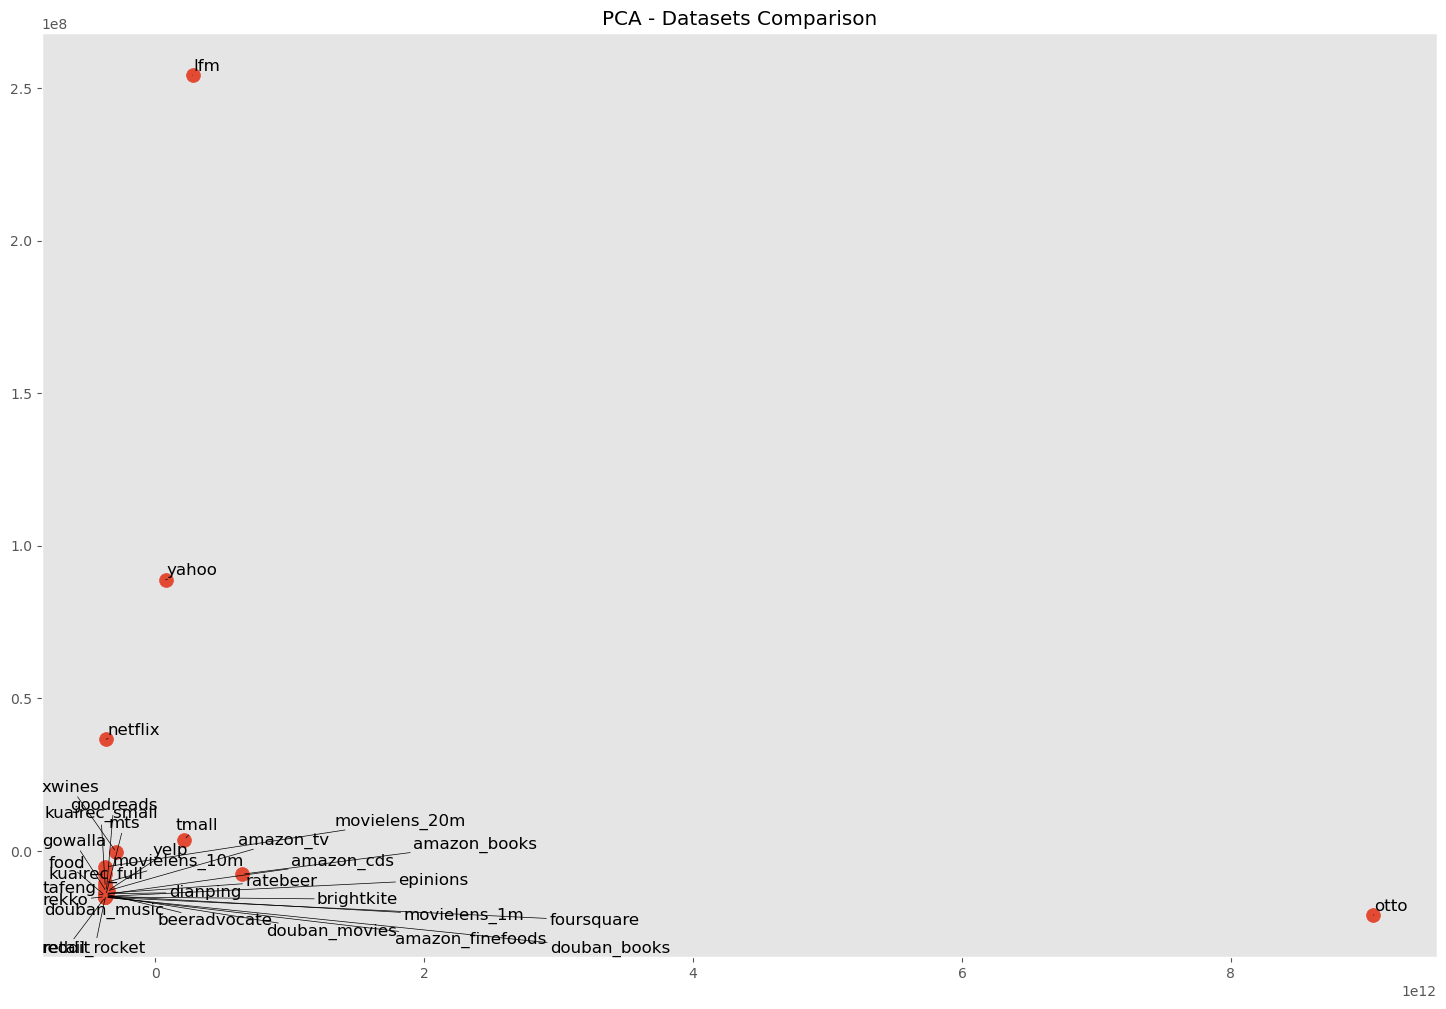

In [52]:
# Perform PCA with 2 components
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(data)

# Create a new DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"], index=data.index)

# Plot the scatter plot of the first two principal components
plt.figure(figsize=(18, 12))
plt.scatter(pca_df["PC1"], pca_df["PC2"], s=100)
plt.title("PCA - Datasets Comparison")
plt.grid()

# Add text labels with adjust_text to avoid overlapping
texts = [plt.text(x, y, dataset, fontsize=12) for dataset, (x, y) in pca_df.iterrows()]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

plt.show()

/opt/conda/envs/wind_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/envs/wind_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


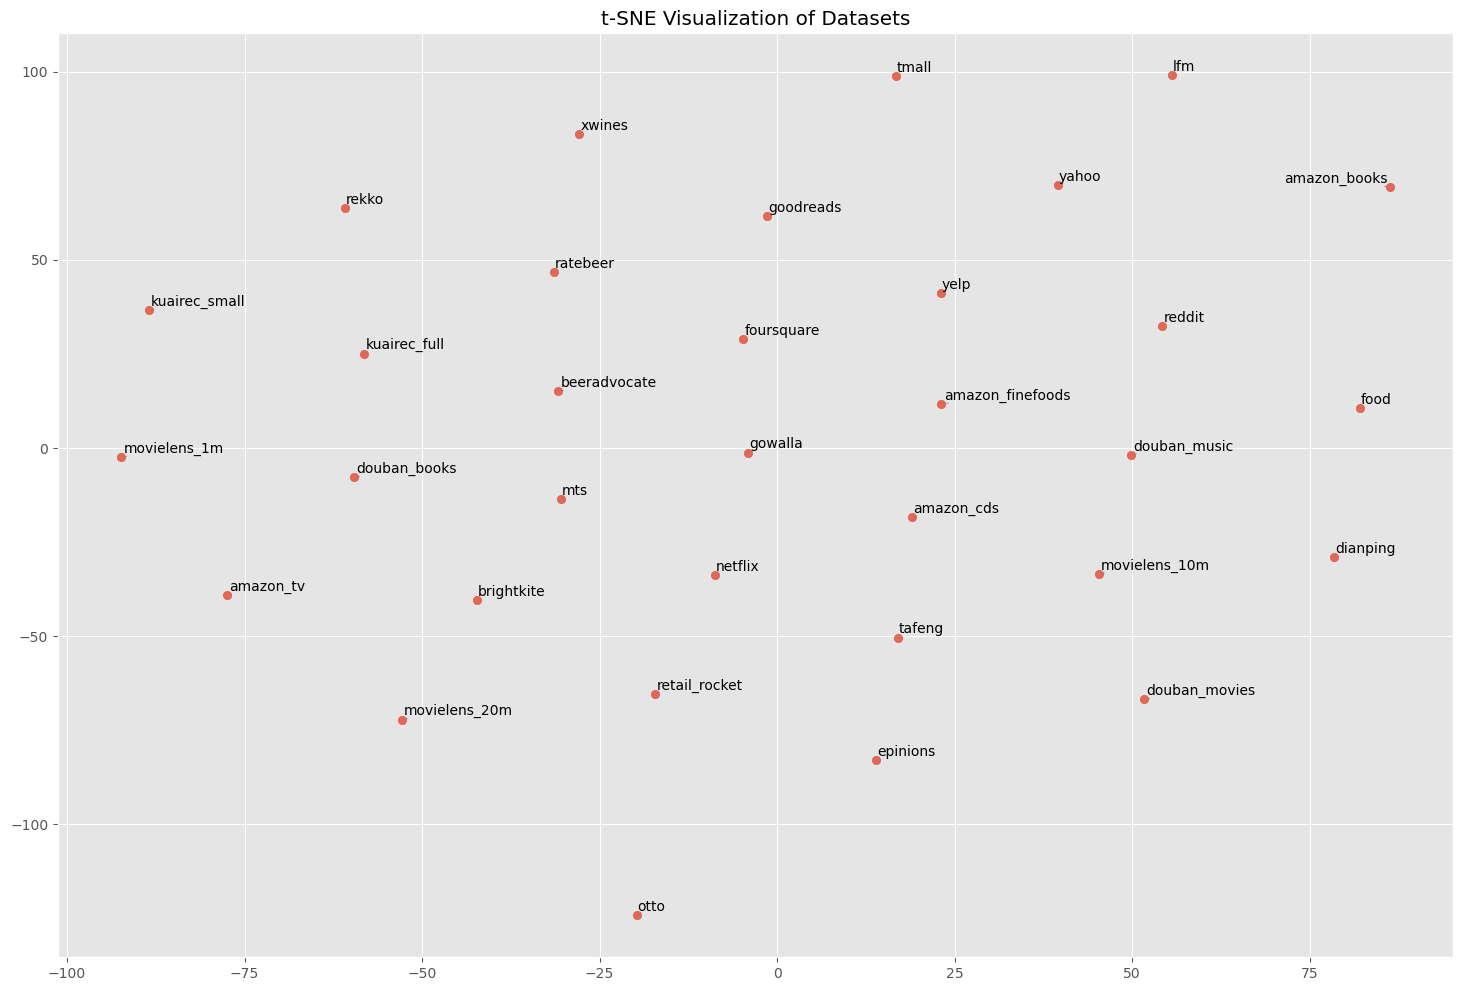

In [53]:
# Plot t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(data)

plt.figure(figsize=(18, 12))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.8)

# Add labels using dataset names
texts = []
for i, dataset in enumerate(data.index):
    texts.append(plt.text(tsne_results[i, 0], tsne_results[i, 1], dataset))

adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="gray"),
    autoalign="xy",
    force_points=0.1,
    force_text=0.1,
)

plt.title("t-SNE Visualization of Datasets")
plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


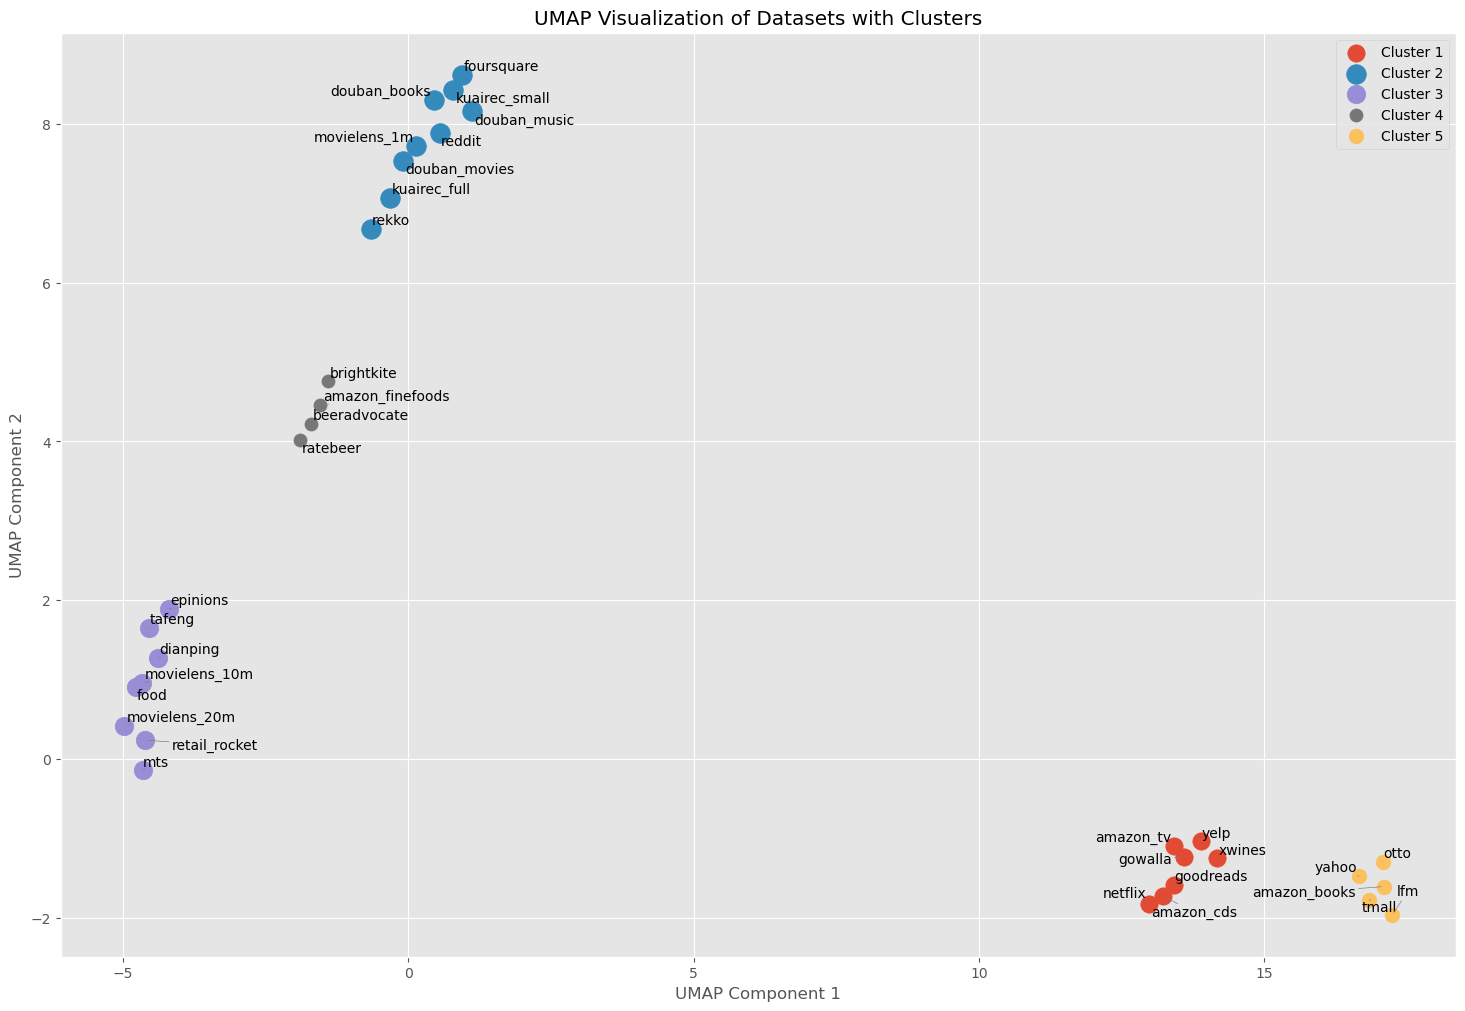

In [54]:
# Dimension reduction using UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, metric="euclidean", random_state=42)
umap_results = umap_reducer.fit_transform(data)

# Clustering using KMeans
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters)
kmeans_labels = kmeans.fit_predict(umap_results)

# Get the size of each cluster
cluster_sizes = np.bincount(kmeans_labels)

# Calculate the scaling factor for circle sizes
max_circle_size = 200 
scaling_factor = max_circle_size / np.max(cluster_sizes)

# Plot UMAP with cluster colors and circle sizes
plt.figure(figsize=(18, 12))
for cluster_num in range(n_clusters):
    cluster_points = umap_results[kmeans_labels == cluster_num]
    cluster_size = cluster_sizes[cluster_num]
    circle_size = cluster_size * scaling_factor
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=circle_size, label=f"Cluster {cluster_num + 1}")

# Add labels using dataset names
texts = []
for i, dataset in enumerate(data.index):
    texts.append(plt.text(umap_results[i, 0], umap_results[i, 1], dataset))

adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="gray"),
    autoalign="xy",
    force_points=0.1,
    force_text=0.1,
)

plt.title("UMAP Visualization of Datasets with Clusters")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend()
plt.show()

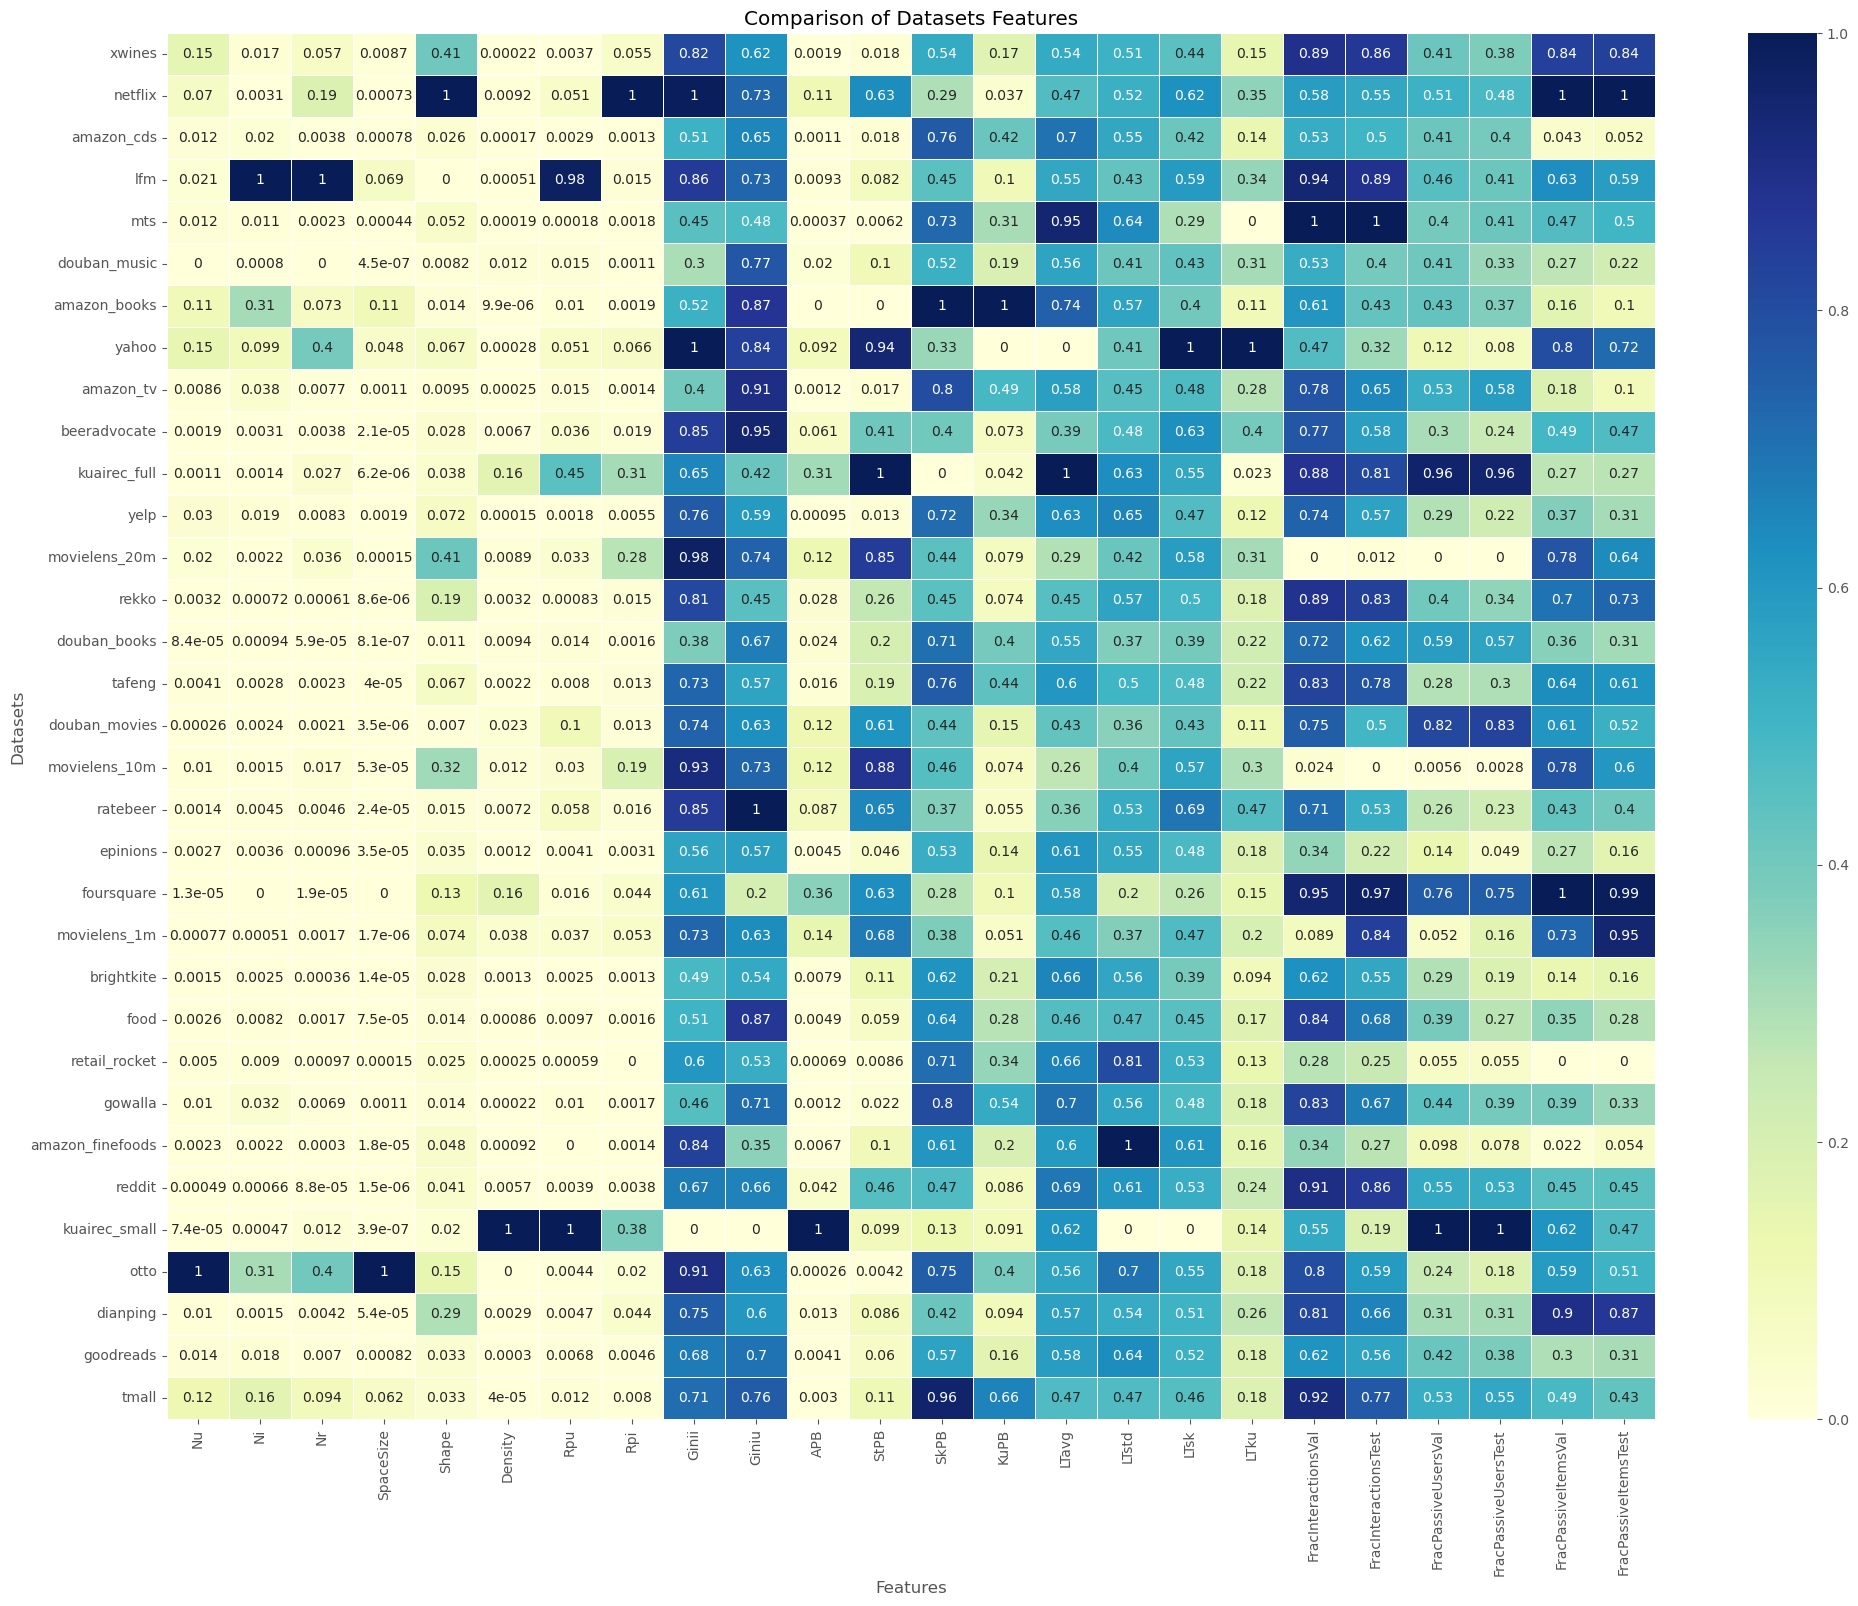

In [12]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(
    scaler.fit_transform(data), columns=data.columns, index=data.index
)
plt.figure(figsize=(24, 18))
sns.heatmap(df_normalized, annot=True, cmap="YlGnBu", vmin=0, vmax=1, linewidths=0.5)
plt.title("Comparison of Datasets Features")
plt.xlabel("Features")
plt.ylabel("Datasets")
plt.show()

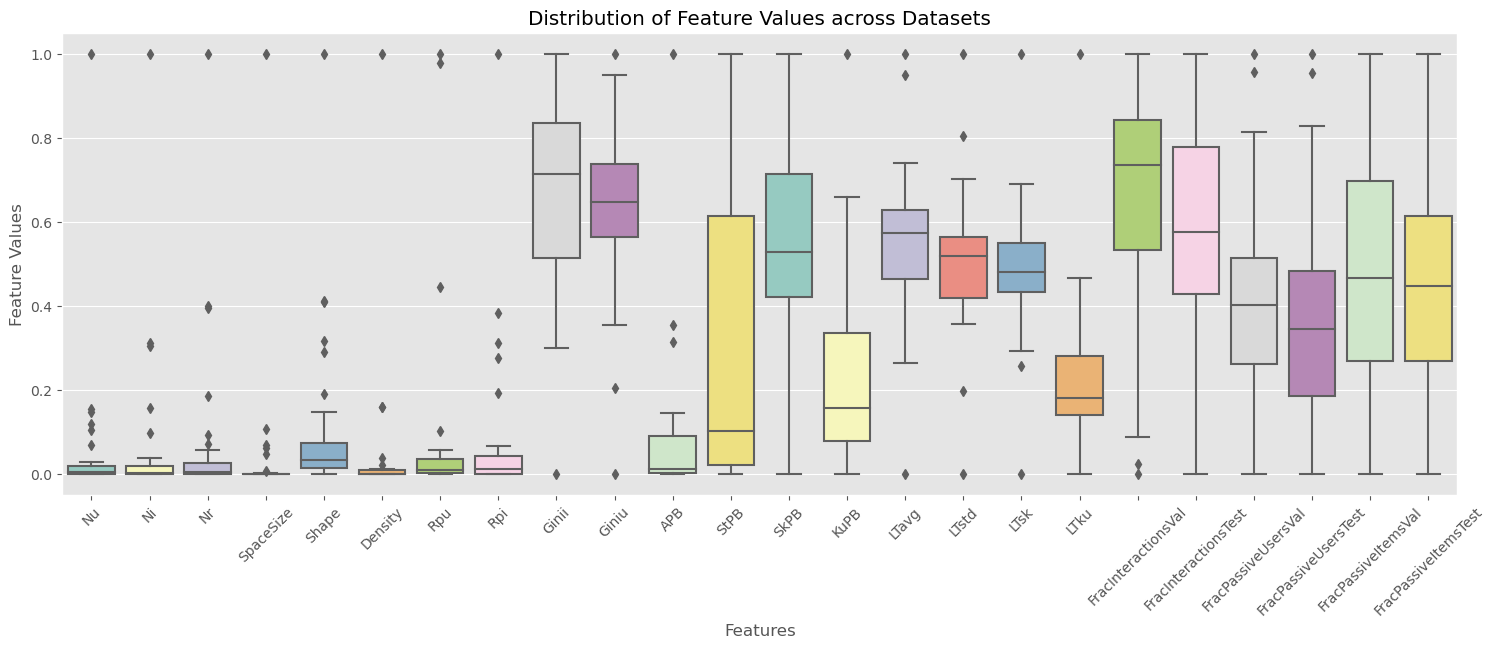

In [13]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=df_normalized, palette="Set3")
plt.title("Distribution of Feature Values across Datasets")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.ylabel("Feature Values")
plt.show()

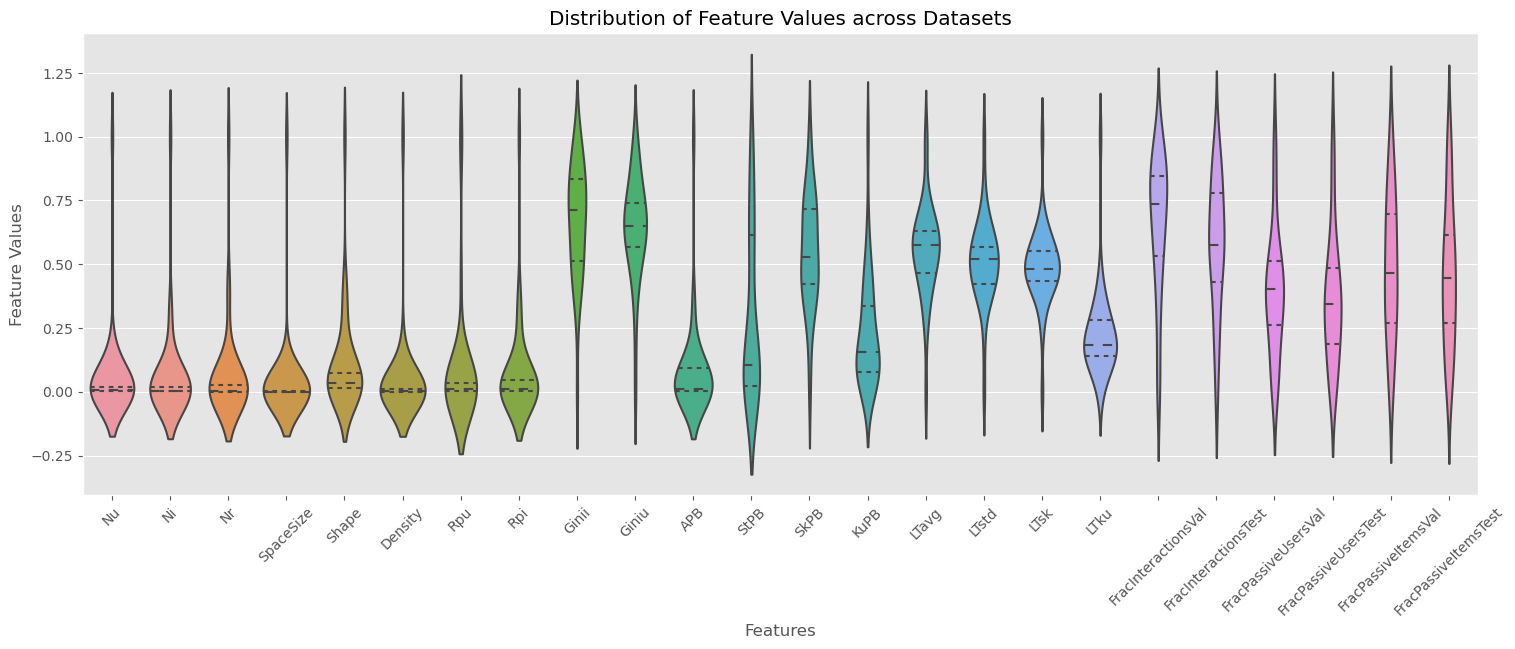

In [57]:
plt.figure(figsize=(18, 6))
sns.violinplot(data=df_normalized, inner="quart")
plt.title("Distribution of Feature Values across Datasets")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.ylabel("Feature Values")
plt.show()

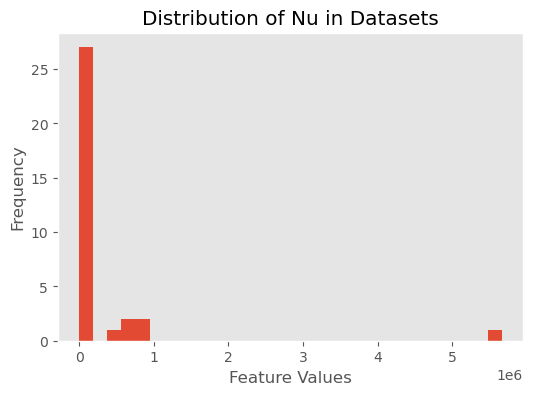

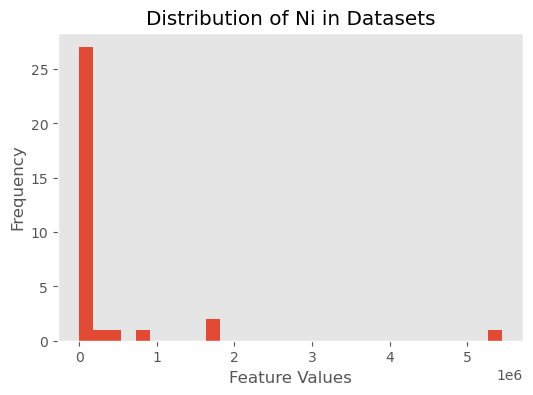

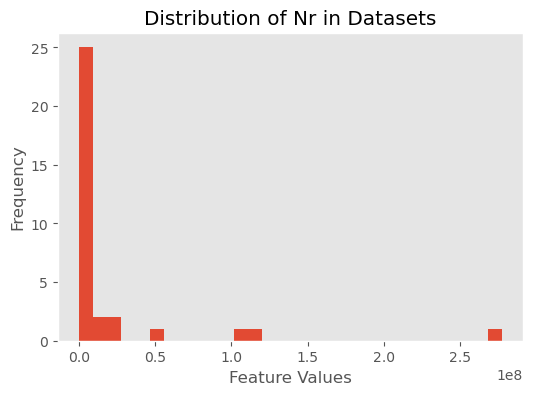

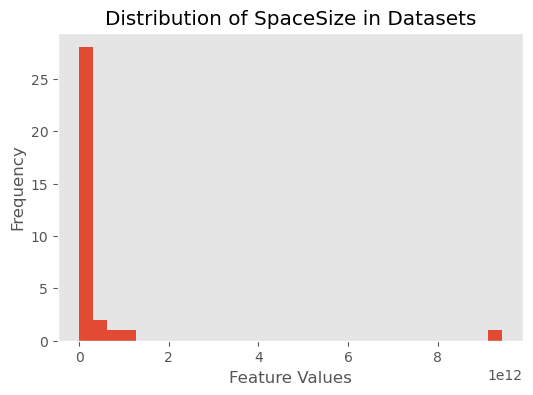

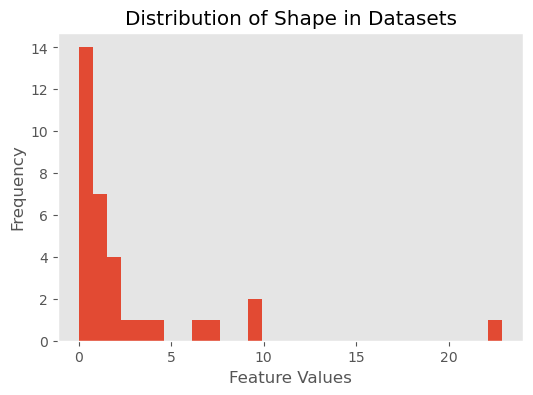

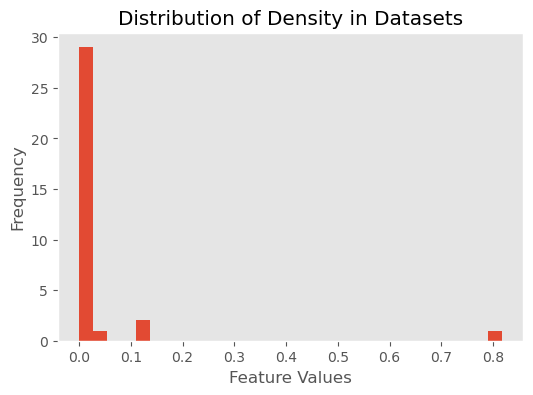

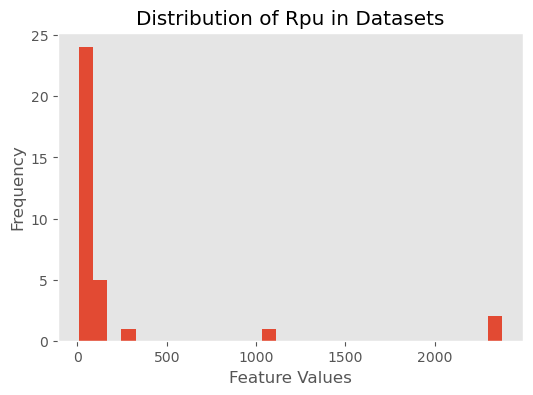

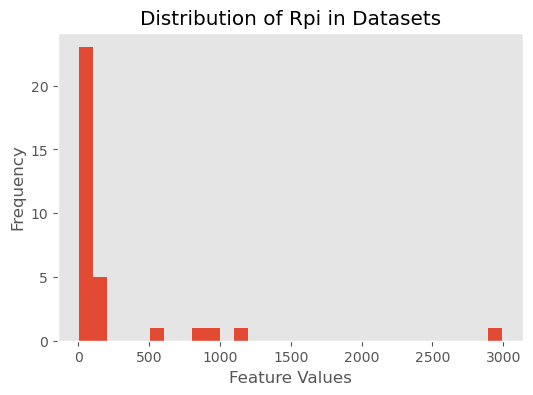

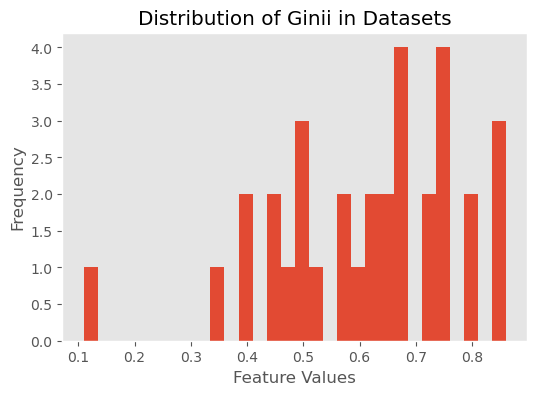

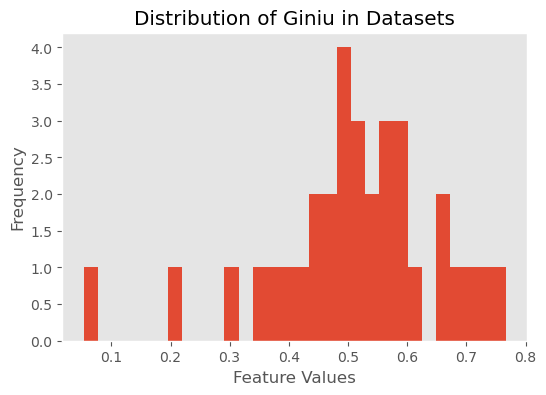

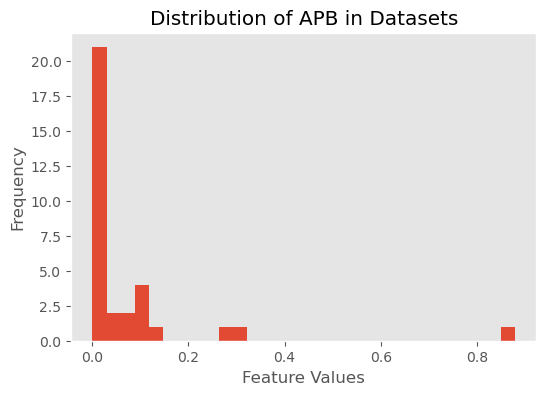

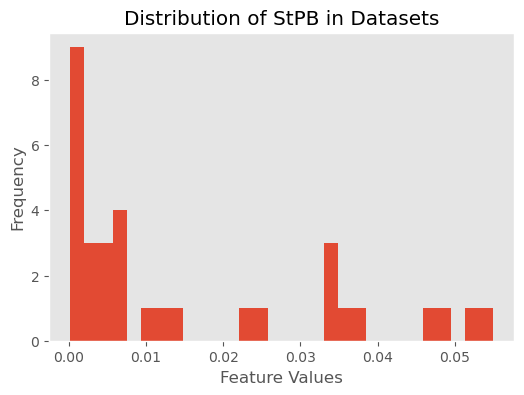

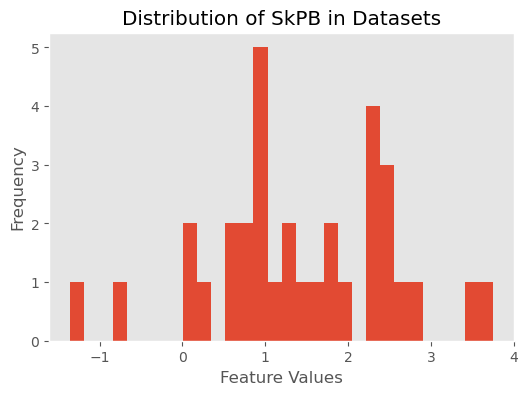

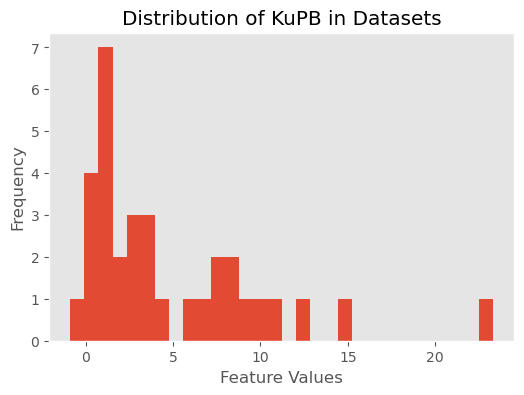

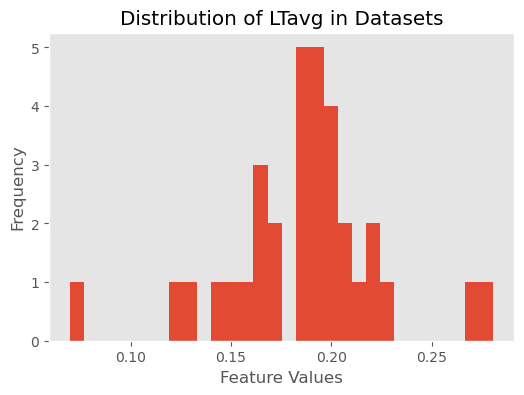

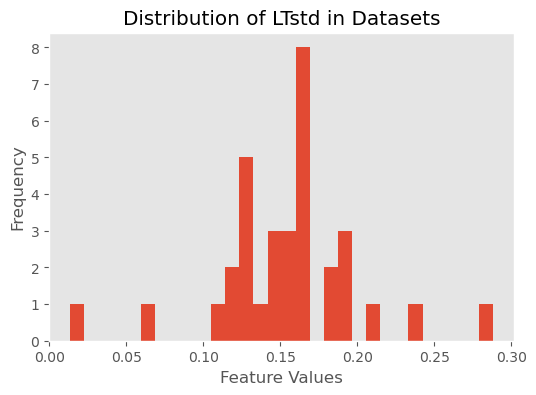

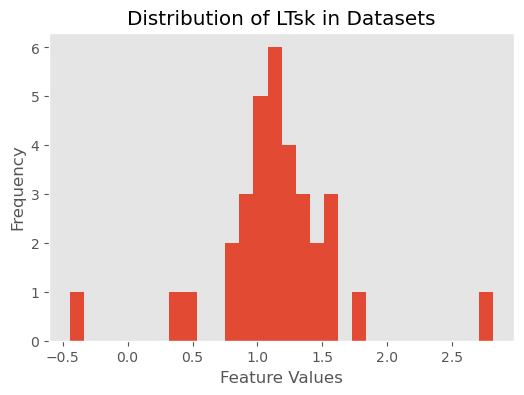

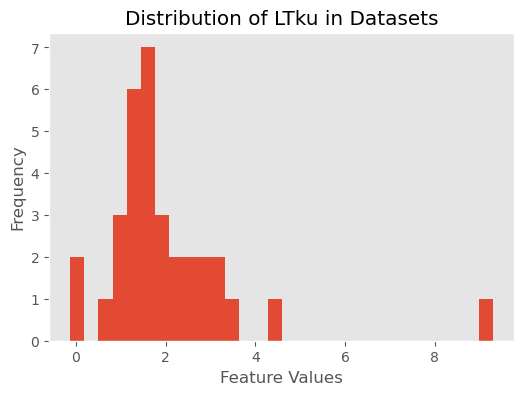

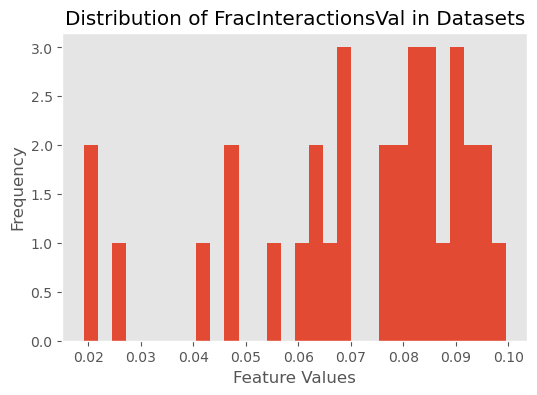

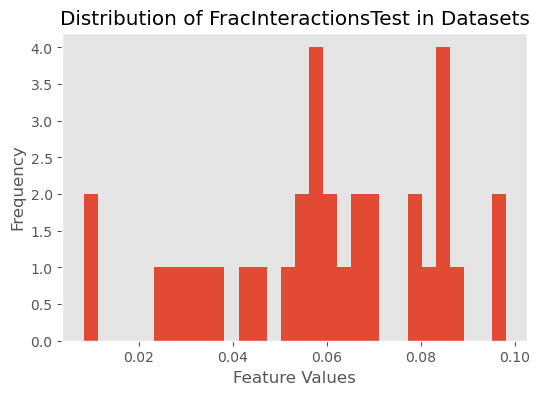

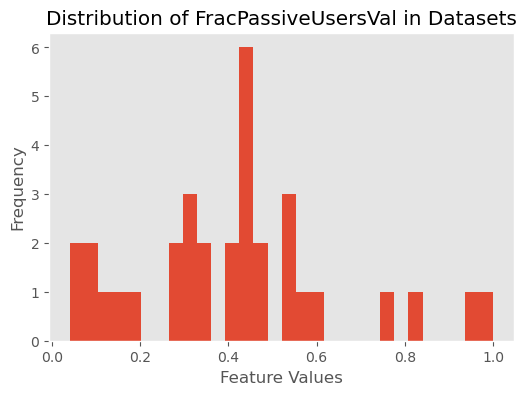

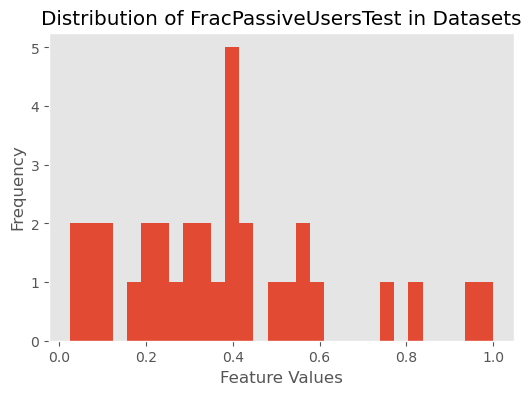

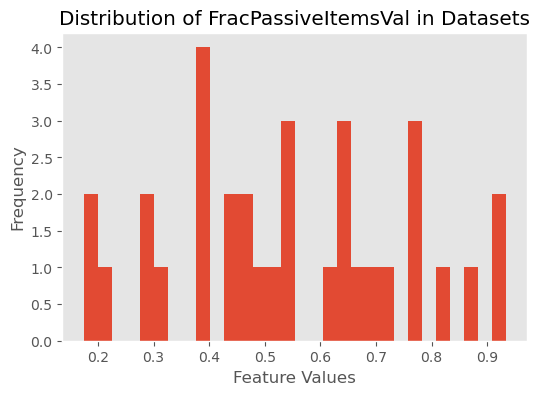

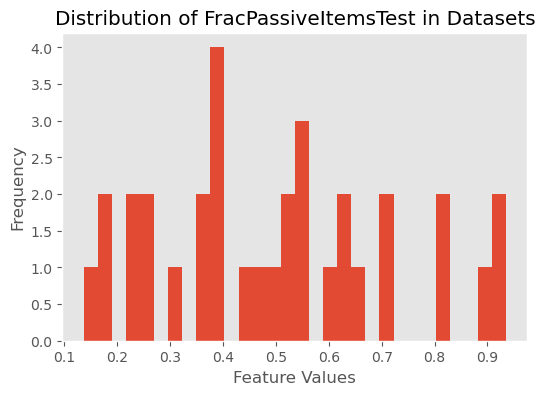

In [66]:
# Create separate figures for each feature's histogram
for feature in data.columns:
    plt.figure(figsize=(6, 4))
    plt.hist(data[feature], bins=30)
    plt.xlabel("Feature Values")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {feature} in Datasets")
    plt.grid()
    plt.show()